For details of YOLOv3, please refer to the paper: https://arxiv.org/pdf/1804.02767v1.pdf

Source code: https://zhuanlan.zhihu.com/p/340300381 (Chinese)

Or: https://github.com/YunYang1994/TensorFlow2.0-Examples/tree/master/4-Object_Detection/YOLOV3

## Input all libraries here

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import re
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import tensorflow as tf
from sklearn.model_selection import train_test_split
from IPython.display import display
from PIL import Image
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Input, LeakyReLU, Concatenate, UpSampling2D, ZeroPadding2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pickle
from sklearn.metrics import mean_squared_error


## Define darknet53 (backbone)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

#Here we define a residual block to make it more convient to implement darknet53
def residual_block(x, num_filters, filter_size):
    # Shortcut connection
    shortcut = x

    # First convolutional layer (1x1 filter to reduce the number of channels)
    x = Conv2D(num_filters, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer (3x3 filter)
    x = Conv2D(num_filters * 2, (filter_size, filter_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Adding the shortcut to the output
    x = Add()([x, shortcut])
    
    return x

def darknet53(input_layer):
    
    x = layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu')(input_layer)
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    for i in range(1):
        x = residual_block(x, 32, 3)
    
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    for i in range(2):
        x = residual_block(x, 64, 3)
    
    x = layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    for i in range(8):
        x = residual_block(x, 128, 3)
    route_1 = x
    
    x = layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    for i in range(8):
        x = residual_block(x, 256, 3)
    route_2 = x
    
    x = layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    
    for i in range(4):
        x = residual_block(x, 512, 3)
    
    return route_1, route_2, x#The reason why we do this is because YOLOv3 extracts features in three different sizes

## Define the remaining structure of YOLOv3

In [3]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Concatenate, UpSampling2D, ZeroPadding2D, Concatenate

def YOLOv3(input_layer, num_classes=15):
    route_1, route_2, conv = darknet53(input_layer)

    #large size objects
    conv = Conv2D(512, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(512, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(512, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv_lobj_branch = Conv2D(1024, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv_lobj_branch = BatchNormalization()(conv_lobj_branch)
    conv_lobj_branch = LeakyReLU(alpha=0.1)(conv_lobj_branch)

    # Output for large-size objects
    conv_lbbox = Conv2D(3 * (num_classes + 5), (1, 1), strides=(1, 1), padding='same', use_bias=True)(conv_lobj_branch)
    
    
    #mid size objects
    conv = Conv2D(256, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    # Upsampling and concatenation
    conv = UpSampling2D(size=(2, 2))(conv)
    conv = Concatenate()([conv, route_2])

    conv = Conv2D(256, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(256, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(512, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(256, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv_mobj_branch = Conv2D(512, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv_mobj_branch = BatchNormalization()(conv_mobj_branch)
    conv_mobj_branch = LeakyReLU(alpha=0.1)(conv_mobj_branch)

    # Output for mid-size objects
    conv_mbbox = Conv2D(3 * (num_classes + 5), (1, 1), strides=(1, 1), padding='same', use_bias=True)(conv_mobj_branch)
    
    
    #tiny size objects
    conv = UpSampling2D(size=(2, 2))(conv)
    conv = Concatenate()([conv, route_1])

    conv = Conv2D(128, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(128, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv = Conv2D(128, (1, 1), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    conv_sobj_branch = Conv2D(256, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(0.0005))(conv)
    conv_sobj_branch = BatchNormalization()(conv_sobj_branch)
    conv_sobj_branch = LeakyReLU(alpha=0.1)(conv_sobj_branch)

    # Output for tiny-size objects
    conv_sbbox = Conv2D(3 * (num_classes + 5), (1, 1), strides=(1, 1), padding='same', use_bias=True)(conv_sobj_branch)
    
    conv_sbbox = Conv2D(30, (1, 1), strides=(1, 1), padding='same', activation='linear')(conv_sbbox)
    conv_mbbox = Conv2D(30, (1, 1), strides=(1, 1), padding='same', activation='linear')(conv_mbbox)
    conv_lbbox = Conv2D(30, (1, 1), strides=(1, 1), padding='same', activation='linear')(conv_lbbox)
    
    model = Model(inputs = input_layer, outputs = [conv_sbbox, conv_mbbox, conv_lbbox])
    return model

## Compile the model (here we slightly modify the NN to make it compatible with our output)

In [4]:
model = YOLOv3(Input(shape =(96, 96, 3)))

output1 = model.layers[-3].output  # 12*12*30
output2 = model.layers[-2].output  # 6*6*30
output3 = model.layers[-1].output  # 3*3*30

# Apply global average pooling to each output
pooled_output1 = GlobalAveragePooling2D()(output1)
pooled_output2 = GlobalAveragePooling2D()(output2)
pooled_output3 = GlobalAveragePooling2D()(output3)

# Concatenate the pooled outputs
concatenated_outputs = Concatenate()([pooled_output1, pooled_output2, pooled_output3])

# Fully connected layer to get the keypoints
keypoints = Dense(30, activation='linear')(concatenated_outputs)

# Create the new model
custom_model = Model(inputs=model.input, outputs=keypoints)

# Compile and train the model
custom_model.compile(optimizer = Adam(learning_rate = 0.001), loss='mean_squared_error')

# Print model summary
custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 48, 48, 32)   2080        conv2d_1[0][0]                   
____________________________________________________________________________________________

## Define Useful Functions

In [5]:
def sort_pattern(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def sort_pattern(filename):
    # Extract numerical part of the filename for sorting, assuming the format 'name_number.jpg'
    num_part = ''.join(filter(str.isdigit, filename))
    return int(num_part) if num_part.isdigit() else float('inf')  # Return a large number if no digits found

def load_images(path):
    images = []
    file_list = os.listdir(path)
    sorted_files = sorted(file_list, key=sort_pattern)

    for filename in sorted_files:
        if filename.endswith(".jpg"):
            img_path = os.path.join(path, filename)
            # Open the image and convert it to grayscale
            img = Image.open(img_path).convert('L')
            # Convert the grayscale image to RGB
            img_rgb = img.convert('RGB')# The reason why we convert it to RGB is because 
            # Append the RGB image as a NumPy array to the images list
            images.append(np.array(img_rgb))
            img.close()

    return images

def show_keypoints(images, keypoints, n_rows=3, n_cols=7):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2 * n_cols, 2 * n_rows), dpi=100)

    for i, ax in enumerate(axes.flatten()):
        img_array = np.array(images[i], dtype=np.uint8)  # Convert list of images to NumPy array
        img_array = img_array.squeeze()  # Remove singleton dimensions
        img = Image.fromarray(img_array)  # Convert NumPy array to PIL Image
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Sample #{i}')

        for j in range(0, len(keypoints[i]), 2):
            x = keypoints[i][j]
            y = keypoints[i][j + 1]
            ax.plot(x, y, 'ro', markersize=2)

    plt.tight_layout()
    plt.show()

## Train the model
#### Here I did 100 epoches in my Spyder instead of doing it on Jupyter Notebook directly since my GPU does not work here.

In [6]:
train_data = pd.read_csv('training.csv')
path = r"images\train_images"
images = load_images(path)
#show_keypoints(images[:21], train_data.values[:21])

train_data.isna().mean().round(4) * 100
train_data.fillna(train_data.describe().T['50%'], inplace=True)
train_data.sample(5).T

x_train = np.array(images).reshape(-1, 96, 96, 3).astype('float64')
y_train = train_data.values.astype('float64')

# Reduce learning rate for improving convergence, and early stopping
# Dynamically adjust learning rate
early_stopping = EarlyStopping(monitor='loss', patience=30, mode='min', baseline=None)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-15, mode='min', verbose=1)

callback = tf.keras.callbacks.TerminateOnNaN()
history = custom_model.fit(x_train, y_train, validation_split=0.2, epochs = 100, callbacks=[reduce_LR, early_stopping], batch_size=32)

# Save the model
custom_model.save('YOLOv3.h5')
with open('History-YOLOv3.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
 31/177 [====>.........................] - ETA: 16s - loss: 1813.5543

KeyboardInterrupt: 

## Here is part of the training process
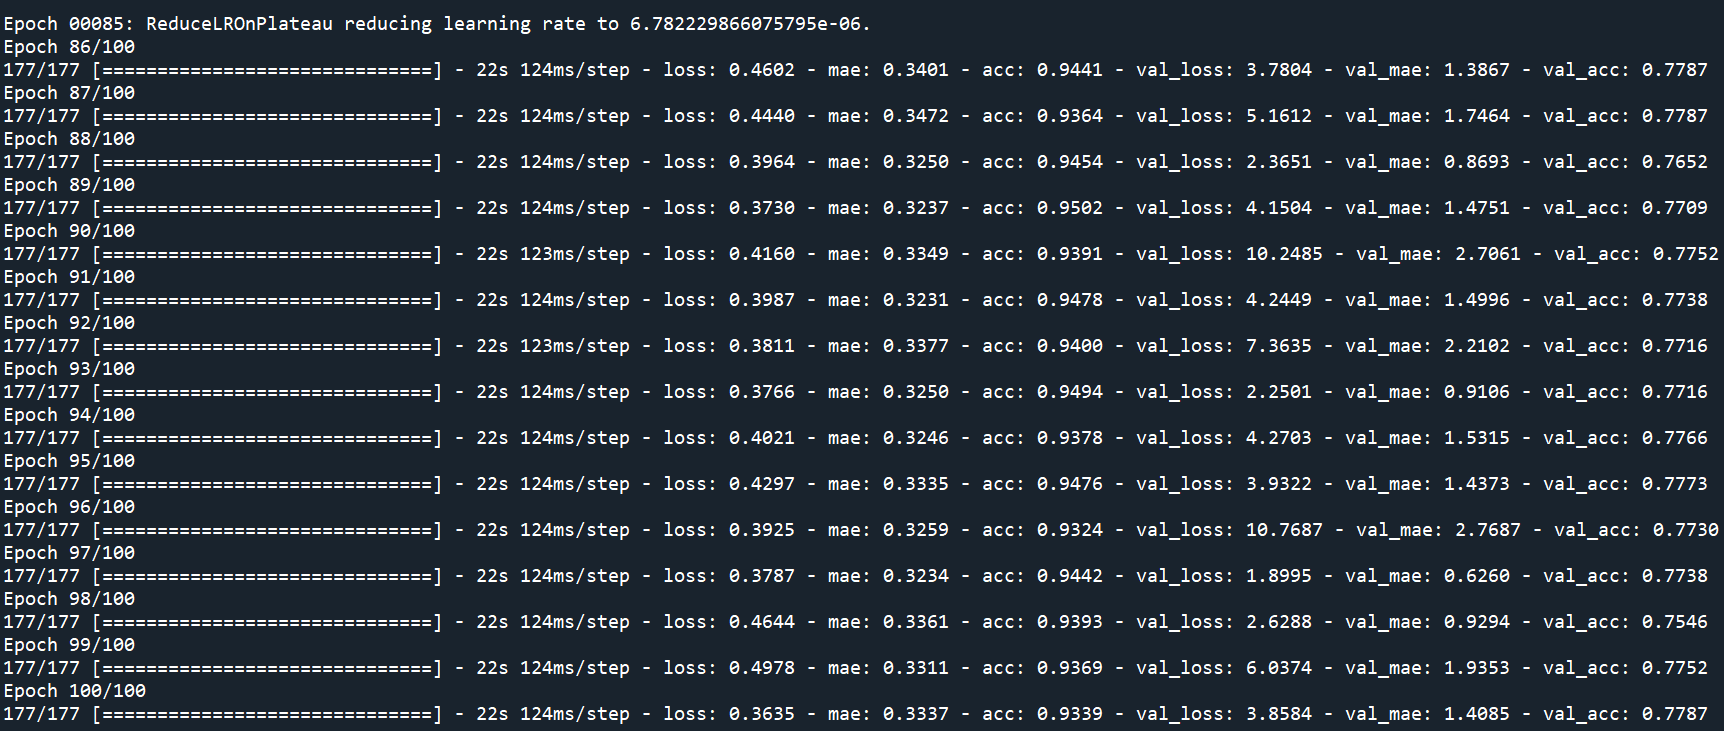

## Test the model with test images and report its MSE
### Here I directly use my trained "YOLOv3.h5" model to verify its performance

[[64.12096405 38.07023239 28.27822685 ... 65.78536224 47.47832108
  86.09789276]
 [65.31255341 35.63076019 26.82989311 ... 70.94883728 47.98922348
  85.68927765]
 [64.94651794 35.32418823 29.66211891 ... 70.02896881 48.21110916
  83.04063416]
 ...
 [65.22581482 44.02244186 33.07826996 ... 70.75312805 45.29565811
  76.3806076 ]
 [62.20553589 36.66347504 30.43029594 ... 71.11026001 44.48642349
  72.65708923]
 [65.72536469 38.87985992 29.95976257 ... 70.80374146 44.8883667
  80.57566833]]


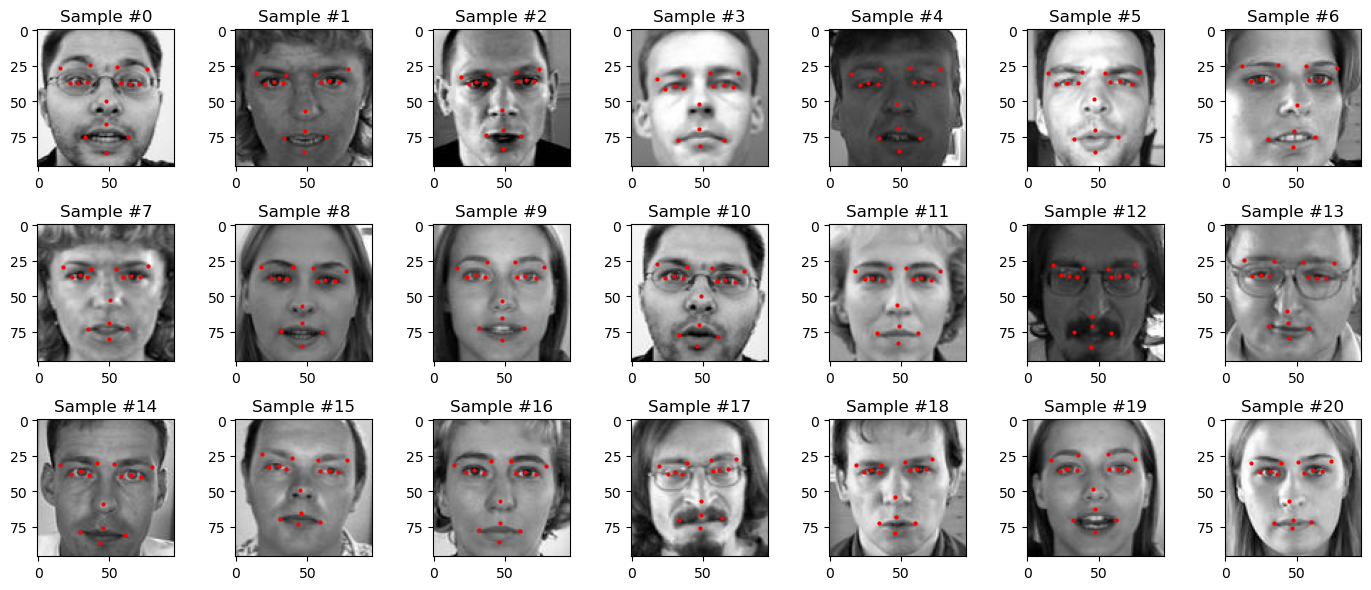

Training MSE: 2.1792724306995415


In [7]:
path = r"images\test_images"
test_img = load_images(path)
YOLOv3 = load_model('YOLOv3.h5')
test_img_array = np.stack(test_img, axis=0)  # Stack the list of images
x_test = test_img_array.reshape(-1, 96, 96, 3).astype('float64')
y_test = YOLOv3.predict(x_test).astype('float64')
print(y_test)
show_keypoints(x_test[:21], y_test[:21])

y_train_pred = YOLOv3.predict(x_train).astype('float64')
train_mse = mean_squared_error(y_train, y_train_pred)
print(f'Training MSE: {train_mse}')

## Model analysis and evaluation

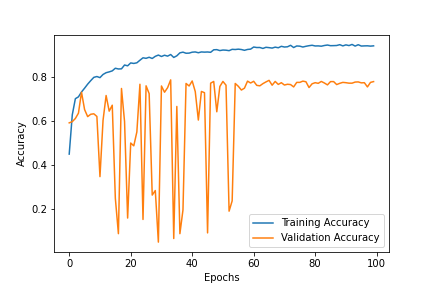

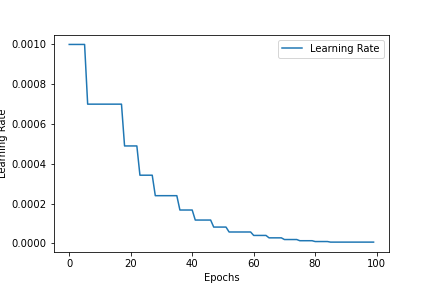

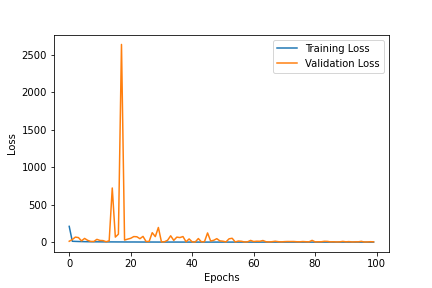

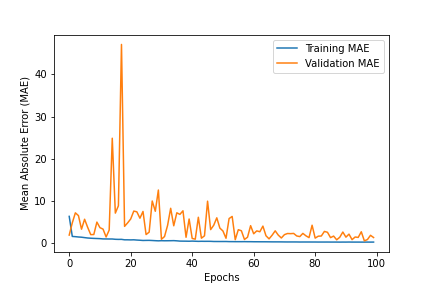